# Modul 3: Maschinelles Lernen – Ein Deep-Dive in die KI

## Session 2 – Implementierung eines Modells (adaptiert von Jan Batzner und Panagiota Xydi)
<br>

#### *Hertie School of Governance, Dylan Thurgood, November 2025*


<br>

# **Textklassifikation zur E-Mail-Kategorisierung im Bürgeramt**

## Vorbemerkung
Diese Übung setzt keinerlei Coding-Kenntnisse voraus und Ihr dürft den Code gerne weitestgehend ignorieren. In diesem Notebook könnt Ihr ihn einfach mit [Shift] + [Return] ausführen. Der eigentliche Code, der die verschiedenen Funktionen schreibt, ist deutlich länger und befindet sich auf GitHub. Er ist "versteckt" eingebettet durch das Package "tools".

Bei Interesse könnt Ihr Euch den gesamten Code im [Github Repository](https://github.com/janbatzner/Hertie_KI-Modul_SPAM_Classifier) anschauen.

In [1]:
# Vorbereitung
!rm -rf /content/*
import sys
# Diese Zeile importiert das Modul "sys", das nützliche Funktionen für den Zugriff auf Systemfunktionen bietet.
if 'google.colab' in sys.modules:
    !git clone https://github.com/dylanthurgood/hertie_email_classifier_buergeramt.git
    # Hier wird überprüft, ob das Script in Google Colab ausgeführt wird, indem nach dem Colab-Modul gesucht wird.
    # Wenn das Script in Colab läuft, wird mit diesem Befehl das GitHub-Repository mit den benötigten Dateien heruntergeladen.
    # Wir kopieren die notwendigen Files von GitHub und installieren packages mit pip
    !cp -r "hertie_email_classifier_buergeramt/data" "hertie_email_classifier_buergeramt/tools.py" .
    # Diese Zeile kopiert die Daten und das Skript "tools.py" aus dem geklonten Verzeichnis in das aktuelle Arbeitsverzeichnis.
    !pip install -r "hertie_email_classifier_buergeramt/colab-requirements.txt"
    # Hier werden alle nötigen Python-Pakete installiert, die im "colab-requirements.txt" aufgelistet sind.
    # Zum Neustart der Runtime: falls nötig das "#" der unteren beiden Zeilen entfernen
    # Diese Zeilen ist auskommentiert (#) und würde das Modul "os" importieren, das zur Steuerung von Betriebssystemfunktionen verwendet wird.
    # Die zweite Zeile (ebenfalls auskommentiert) würde das aktuelle Python-Programm beenden, um die Laufzeitumgebung neu zu starten.
    # import os
    # os.kill(os.getpid(), 9)
import warnings
warnings.filterwarnings('ignore')

Cloning into 'hertie_email_classifier_buergeramt'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 73 (delta 30), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 1.11 MiB | 5.00 MiB/s, done.
Resolving deltas: 100% (30/30), done.


## Aufgabe

Im Bürgeramt gehen täglich zahlreiche E-Mails mit diverse Anliegen ein, was eine manuelle Sortierung zeitaufwendig macht. Ein automatischer E-Mail-Klassifizierer kann Anfragen den richtigen Kategorien oder Sachbearbeitenden zuordnen und so den Verwaltungsalltag erleichtern.

In dieser Übung entwickeln wir einen einfachen Klassifizierer, der anhand von Beispielen lernt, um welche Art von Anliegen es sich in einer E-Mail handelt – z.B. Terminanfragen, Ausweis- oder Meldeangelegenheiten – und neue, bislang unbekannte, Nachrichten automatisch vorsortieren kann. Ziel ist es, ein grundlegendes Verständnis dafür zu gewinnen, wie Textdaten verarbeitet und für maschinelles Lernen genutzt werden können.

Wir verwenden dazu einen für diesen Zweck erzeugten synthetischen E-Mail-Datensatz. Dieser Datensatz enthält ungefähr 6.500 gelabelte E-Mails und wurde mit OpenAI's GPT-4.1-Nano Modell generiert - der Prompt gab vor zu sieben verschiedenen Kategorien (s.u.) E-Mails zu generieren und dabei Formalität, Länge, Ton und Tippfehler zu variieren. Der Datensatz liegt im *data*-Ordner auf [Github](https://github.com/dylanthurgood/hertie_email_classifier_buergeramt). Wir greifen mit diesem Notebook auf den Datensatz zu.
<br><br>

## Begrifflichkeiten
In der Welt der Textverarbeitung werden Sammlungen von Texten oft als "Korpora" bezeichnet. Ein gesamter Textdatensatz, der mehrere einzelne Texte enthält, wird folglich als Korpus bezeichnet. Einzelne Texte oder Einträge innerhalb dieses Korpus werden als **Dokumente** bezeichnet. In diesem Zusammenhang bezieht sich ein Dokument auf eine einzelne E-Mail, die Teil des größeren Korpus ist.
- **Korpus**: Im Fall unseres synthetischen E-Mail-Datensatzes stellt das gesamte Set an E-Mails den Korpus dar.
- **Dokument**: Jede einzelne E-Mail innerhalb dieses Datensatzes wird als Dokument betrachtet.
<br>

## Überblick über das Notebook
1. Laden der Daten
2. Textvorverarbeitung
3. Datenexploration
4. Feature Engineering
5. Entwicklung eines Email-Klassifizierers
6. Evaluation des Modells

# **1. Laden des E-Mail-Datensatzes**

In [2]:
# Laden der Helferfunktionen und Libraries:
# In der Library "Tools" sind alle Funktionen abgelegt, die wir heute benötigen.
# Falls Ihr Euch für den ganzen Code interessiert, schaut gerne im GitHub Repository nach.
import tools

# Laden des Datensatzes
df = tools.pd.read_json("data/emails_synthetisch.json")

Der Datensatz ist nun als sogenanntes Data Frame mit Namen *df* gespeichert.

In [3]:
# Wir bereiten den Datensatz etwas auf:
order = ["Meldewesen","Ausweisdokumente","Unterlageneinreichung","Termin","Beschwerden","Sonstige Anfragen","Spam"]
df = tools.prepare_df(df, order=order,
                keep_cols=["Eingangsnummer","Von","Datum","Betreff","Nachrichtentext","Klassen-Label"],
                subject_col="Betreff", text_col="Nachrichtentext", combine_col_name="Email")

# Wir können zur im Anschluss entweder die gesamten Email inklusive Betreff ("Email") oder nur den Text ("Nachrichtentext") zur Kategorisierung ausprobieren
text_col = tools.choose_text_column(df, ["Email", "Nachrichtentext"])

Lasst uns nun einige E-Mails im Datensatz genauer betrachten.

Hierzu nehmen wir eine Stichprobe von drei E-Mails (*sample*). Ihr könnt die Zahl nach Belieben anpassen.

Jede Email ist einer der folgenden Klassen zugeordnet ("True Labels"):
- Meldewesen
- Ausweisdokumente
- Unterlageneinreichung
- Termin
- Beschwerden
- Sonstige Anfragen
- Spam

In [ ]:
# Wir nehmen eine Stichprobe (sample) von drei Dokumenten (E-Mails) aus unserem Korpus.
# Tauscht Euch mit Eurer/Eurem Sitzbachbar/in aus: Welche E-Mails enthält Eure Stichprobe?
df.sample(3)

,Eingangsnummer,Von,Datum,Betreff,Nachrichtentext,Klassen-Label,Email
6318,89350,b_89350@synthetic.domain,2023-10-02,Ergänzende Unterlagen zu meinem Antrag,"Guten Tag,\n\nim Anhang finden Sie die kopie m...",Unterlageneinreichung,Betreff: Ergänzende Unterlagen zu meinem Antra...
2792,85824,b_85824@synthetic.domain,2023-10-01,Online-Termin buchen – bevorzugte Zeiten erfragen,"<p>Guten Tag,\n\nich möchte einen Termin onlin...",Termin,Betreff: Online-Termin buchen – bevorzugte Zei...
6049,89081,b_89081@synthetic.domain,2023-10-02,Schnell Geld verdienen!,"Hallo,\n\ndu willst dein Einkommen schnell erh...",Spam,Betreff: Schnell Geld verdienen! Nachrichtente...


Wie viele E-Mails enthält der Datensatz insgesamt und wie verteilen sie sich über die sieben Klassen?

Gesamtanzahl an E-Mails: 6551


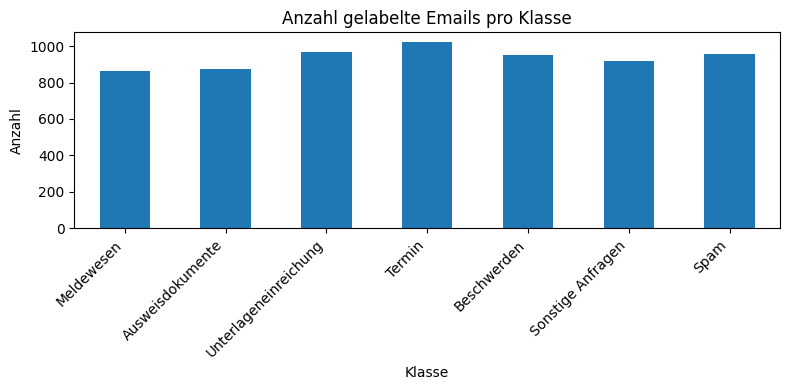

In [4]:
# Wie viele E-Mails enthält der Datensatz insgesamt?
print("Gesamtanzahl an E-Mails: " + str(len(df)))

# Wie viele E-Mails enthält der Datensatz nach Klasse?
tools.plot_class_counts(df, label_col="Klassen-Label", order=order,
                  figsize=(8,4), savepath="class_counts.png", show=True)

# **2. Datenexploration**

Was unterscheidet die verschiedenen E-Mail-Klassen voneinander? In einem ersten Schritt schauen wir uns an, ob die Präsenz von HTML-Tags, URLs oder die Länge der E-Mail Aufschluss geben könnten.

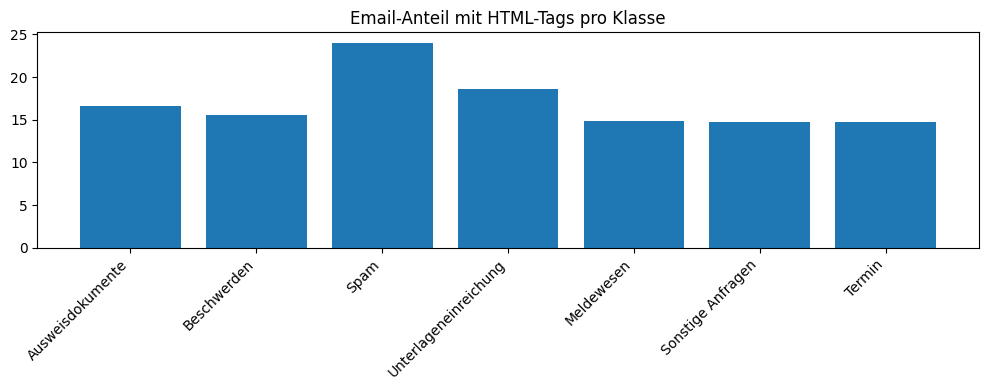

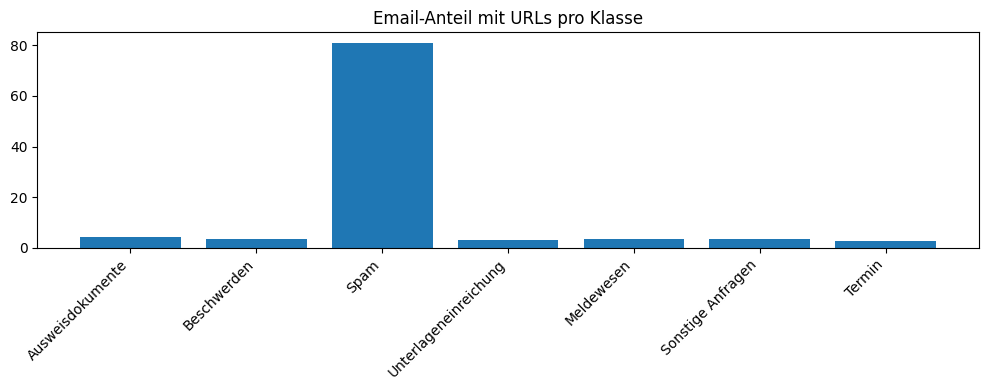

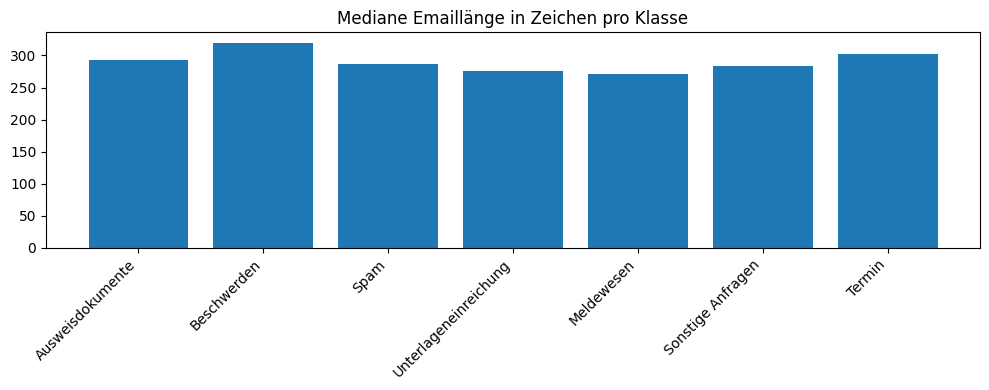

In [5]:
tools.analyze_email_html_urls_length(df)

# **3. Textvorverarbeitung**

Eine gute Textvorverarbeitung ist ein zentraler Schritt in jedem NLP-Projekt. Ziel ist es, Rohtexte zu bereinigen und zu vereinheitlichen, bevor sie einem maschinellen Lernmodell übergeben werden. Dabei möchten wir möglichst viele informative Wörter beibehalten und gleichzeitig uninformative oder störende Elemente entfernen. Durch das Reduzieren von „Rauschen“ im Text lässt sich die Modellleistung und Genauigkeit deutlich verbessern.
<br><br>

Wichtige Aspekte der Textbereinigung können zum Beispiel sein:

* Entfernen von HTML-Tags

* Löschen/Vereinheitlichen von E-Mail-Adressen und evtl. URLs (URLs können z.B. zur Klassifizierung von Spam, wie wir eben gesehen haben, nützlich sein)

* Entfernen von Satzzeichen und Ziffern (z. B. 2002, 1.1 …)

* Reduzieren von mehrfachem Leerzeichen

* Vereinheitlichen der Groß- und Kleinschreibung (z. B. Hund → hund)

* Entfernen häufig vorkommender, nichtssagender Wörter ("Stop Words") wie zum Beispiel: "und", "der", "die", "das", "in", "den", "von","mit", "ist", "ich", "nicht", "für", "auf"

* Erkennen und Anonymisieren personenbezogener Daten (PII) wie Namen, Telefonnummern, Adressen oder Kreditkartennummern, um Datenschutz und Compliance zu gewährleisten

* Ggfs. weitere projektspezifische Schritte, wie das Entfernen von Sonderzeichen oder bestimmten Fachbegriffen.
<br>

Zur Textbereinigung für unseren Datensatz verwenden wir nun die *clean*-Funktion, um Stop Words sowie reine Zahlen zu entfernen.

In [6]:
df["Nachrichtentext"] = tools.clean(df, "Nachrichtentext")
df["Email"] = tools.clean(df, "Email")

# **4. Visualisierung der häufigsten Wörter**




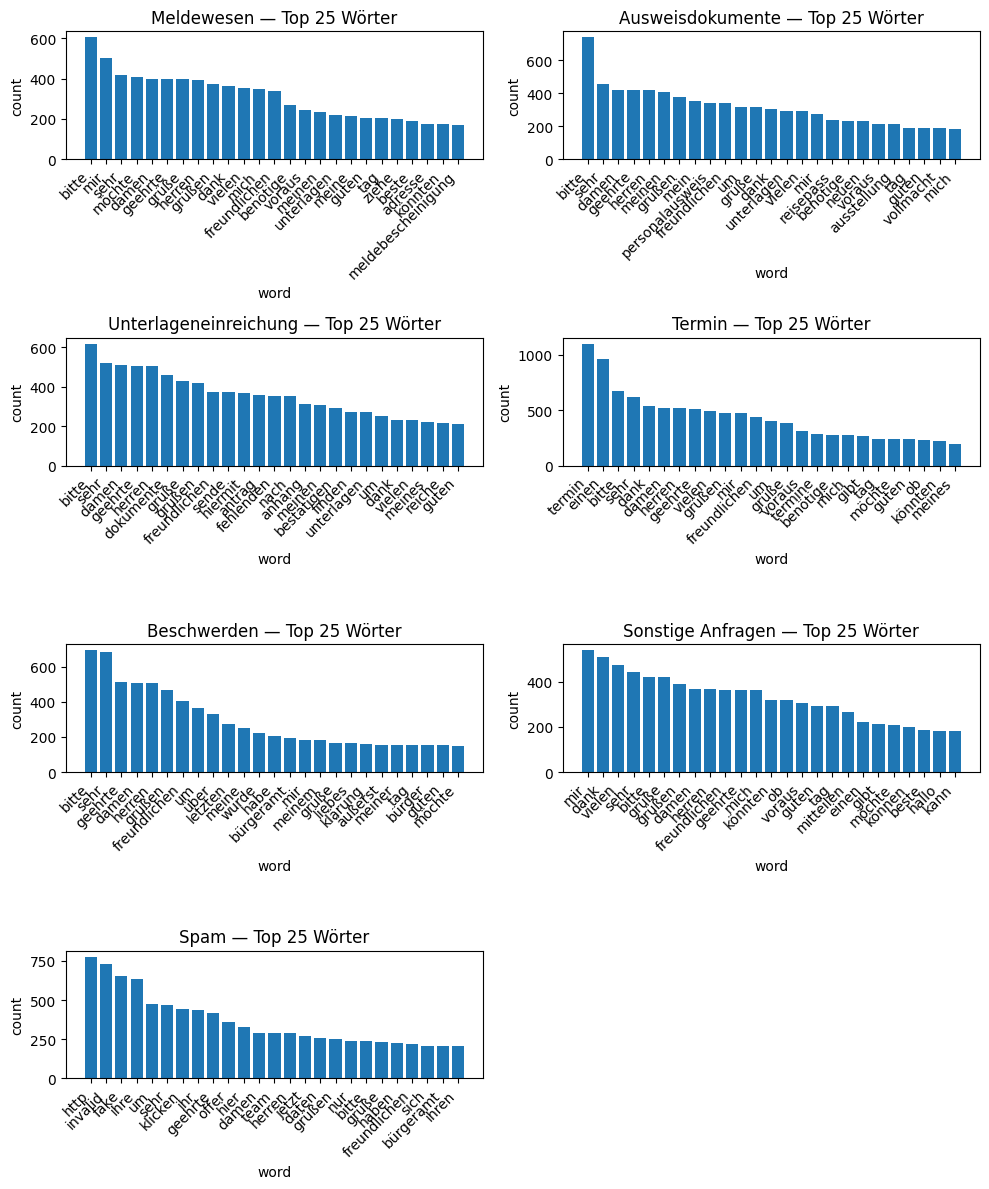

In [7]:
tools.plot_most_common_by_class(df,
    label_col="Klassen-Label",
    text_candidates=["Nachrichtentext"],
    top_n=25,
    common_names=set(),
    order=order,
    figsize_per_plot=(5,3),
    savepath="top_words_by_class.png",
    show=True)

In allen Klassen gehören Wörter, die in Grußformeln enthalten sind, zu den häufigsten ("Sehr geehrte Damen und Herren", "Mit freundlichen Grüßen"), ebenso wie "bitte" oder "danke". Allerdings sehen wir, dass manche häufiger vorkommende Wörter eine Klasse inhaltlich gut treffen wie beispielsweise "Adresse" und "Meldebescheinigung" in der Klasse *Meldewesen* oder "Personalausweis", "Reisepass", "benötige", "Ausstellung" in der Klasse *Ausweisdokumente*.
<br>

Analysieren wir nun, wie sich die sieben Klassen unterscheiden im Hinblick auf die Anzahl der verschiedenen Wörter, die in ihnen vorkommen, sowie die Anzahl der Wörter, die **nur** in dieser Klasse vorkommen!

In [8]:
tools.exclusive_words_by_category(df)


=== Zufällig ausgewählte exklusive Wörter pro Klasse ===

Meldewesen (251 exklusive Wörter insgesamt):
amtlich, terminprozess, umziehe, liefere, auswanderungsprozess, wohnungen, eigentums, niederlande, amtssache, abdrucke, familienumsiedlungen, lasse, kündigen, visum, unbewohnbar, ummeldebestätigung, wechsels, xxx, abmeldeformulare, europäische

Ausweisdokumente (274 exklusive Wörter insgesamt):
reisedokument, studentenausweis, erstellt, entrichten, spätestens, geschäftlich, formvorlage, antreten, lichtbildfotografie, täglichen, tagged, identitätsprüfung, terminings, ersatzbescheinigung, werktage, temporäre, ehefrau, verlängert, neuantrag, reisepassantrag

Unterlageneinreichung (365 exklusive Wörter insgesamt):
az12345, uploads, jane, geduld, gemäß, positive, completedung, fahrzeuganmeldung, wohnungsnachweis, bauantrag, fristgerecht, geburtszeugnisses, testkunde, testperson, maria, ergänzung, zunächst, helga, angeforderte, fehlten

Termin (370 exklusive Wörter insgesamt):
anfordern, d

Klassen-Label,Anzahl verschiedener Wörter,Exklusive Wörter
Spam,2146,1104
Beschwerden,1946,909
Sonstige Anfragen,1590,624
Termin,1320,370
Unterlageneinreichung,1080,365
Ausweisdokumente,1099,274
Meldewesen,982,251


# **5. Entwicklung eines Email-Klassifizierers**

Wir haben nun den Im vorhergehenden Abschnitt haben wir gesehen, wie man Textvorverarbeitung und Merkmalsextraktion aus Texten durchführt. Jetzt sind wir bereit, unser maschinelles Lernmodell zur Klassifizierung von E-Mails zu entwickeln. Wir werden einen Klassifizierer nutzen, der auf [multinomialer logistischer Regression](https://de.wikipedia.org/wiki/Multinomiale_logistische_Regression) basiert.  

Zuerst müssen wir die Daten in zwei Sätze aufteilen: den `Trainingssatz` und den `Testsatz`. Wir werden dann den Trainingssatz nutzen, um unser Modell zu `trainieren`. Der Testsatz wird verwendet, um die Leistung unseres Modells zu `bewerten`. Wir teilen den Datensatz 70/30 auf - der Trainingssatz ist in aller Regel größer als der Testsatz.

### **Beschreibung des Modells**

##### Was ist eine multinomiale logistische Regression?

Die **multinomiale logistische Regression** ist eine Erweiterung der klassischen logistischen Regression. Sie wird verwendet, um die Wahrscheinlichkeit einer **Ausgabe mit mehr als zwei möglichen Klassen** basierend auf einem oder mehreren Prädiktoren (Eingabefaktoren) vorherzusagen.

- **Multiklassen-Klassifikation**: Ideal zur Vorhersage eines Ergebnisses mit mehreren möglichen Klassen, in unserem Fall *„Meldewesen“*, *„Ausweisdokumente“*, *usw*.
  
- **Wahrscheinlichkeitsvorhersage**: Das Modell berechnet für jede Klasse die Wahrscheinlichkeit, dass ein Datenpunkt zu dieser Klasse gehört. Die Klasse mit der höchsten Wahrscheinlichkeit wird dann als Vorhersage ausgewählt.

**Was im Modell passiert:**
1. **Merkmale extrahieren**: Zunächst werden die Texte in numerische Repräsentationen umgewandelt, z. B. mit der Bag-of-Words- oder TF-IDF-Methode.
2. **Modell**: Die multinomiale logistische Regression analysiert diese Merkmale und lernt, welche Kombinationen typischerweise zu welcher Klasse gehören.
3. **Pipeline**: Der gesamte Prozess umfasst die Transformation von Text zu Zahlen sowie das Anwenden des Regressionsmodells, um für jeden neuen Text die Wahrscheinlichkeiten aller Klassen vorherzusagen und die passendste Klasse auszuwählen.


In [9]:
best_model, X_test, y_test, X_train, y_train, class_names = tools.train_tfidf_logreg(
    df,
    text_col="Nachrichtentext",
    label_col="Klassen-Label",
    order=order,
    test_size=0.3,
    cv_folds=2,
    stop_words=list(tools.STOP_WORDS))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


Welche Wörter macht eine Vorhersage für die jeweilige Klasse wahrscheinlicher? Hier sehen wir nun primär die exklusiven Wörter.

In [10]:
import numpy as np
print("\nTop-Begriffe pro Klasse für Vorhersage (basierend auf den Regressionskoeffizienten):")
tfidf = best_model.named_steps["tfidf"]
clf = best_model.named_steps["clf"]
feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_
n_show = 10
for i, label in enumerate(class_names):
    row = coefs[i] if coefs.shape[0] == len(class_names) else coefs[0]
    top_idx = np.argsort(row)[-n_show:][::-1]
    top_tokens = [feature_names[j] for j in top_idx]
    print(f"\n{label}: " + ", ".join(top_tokens))


Top-Begriffe pro Klasse für Vorhersage (basierend auf den Regressionskoeffizienten):

Meldewesen: zweitwohnsitz, meldebescheinigung, mietvertrag, ziehe, adresse, anmelden, ummelden, meldebestätigung, ins, umgezogen

Ausweisdokumente: reisepass, personalausweis, express, mein, vollmacht, ausweis, neuausstellung, verlängerung, meinen, führerschein

Unterlageneinreichung: dokumente, sende, fehlenden, nachweise, finden, nach, antrag, anbei, anhang, reiche

Termin: termin, einen, warteliste, dolmetscher, termine, uhr, termins, slots, kurzfristig, möglich

Beschwerden: klärung, korrektur, berechnet, verbessern, äußerst, bescheid, unhöflich, über, erwarte, wartezeiten

Sonstige Anfragen: interessiere, wählerverzeichnis, gefunden, ferienspiele, aktuellen, parkausweis, wo, öffnungszeiten, müllsäcke, fahrzeug

Spam: http, invalid, ihre, fake, nur, klicken, nachricht, link, ihr, keine


### **Beispiel an einer E-Mail**

Wir betrachten das Model nun anhand von einem Datenpunkt, der E-Mail mit dem **Index 107**. Was sind die vorhergesagten Wahrscheinlichkeiten, dass sie zu den sieben Klassen gehört?
Tauscht den Index gerne aus!

In [11]:
tools.predict_email(df, index=107, model=best_model, class_names=class_names, text_column="Nachrichtentext")

📧 Email:

sehr geehrte damen herren habe einen zweitwohnsitz ihrer stadt möchte diesen anmelden bin mieter einer wohnung musterstraße bitte schicken mir notwendigen unterlagen link zum online formular beste grüße beispielmann erfahren https www buergeramt zweitwohnsitz anlage mietvertrag

📊 Klassifizierungs-Wahrscheinlichkeiten:

Meldewesen: 0.950
Sonstige Anfragen: 0.016
Spam: 0.015
Beschwerden: 0.012
Ausweisdokumente: 0.004
Termin: 0.001
Unterlageneinreichung: 0.001

✅ Vorhergesagte Klasse: Meldewesen


'Meldewesen'

# **6. Evaluation des Modells**

### **Metriken**  
Zur Evaluation des Modells können wir folgende Metriken berechnen:

- **Accuracy** = (TP+TN) / (TP+FP+FN+TN)
- **Precision** = TP / (TP+FP)
- **Recall** = TP / (TP+FN)
- **F1 Score** = 2 (Precision * Recall) / (Precision + Recall).
<br>

Hierbei gilt:
- TP = True Positives
- TN = True Negatives
- FP = False Positives
- FN = False Negatives.
<br>

### **Confusion Matrix**  
Konfusionsmatrizen sind eine gute Möglichkeit, die Leistung von Klassifikationsmodellen zu visualisieren. Zeilen entsprechen den tatsächlichen Klassen und Spalten den vorhergesagten Klassen. Einträge auf der Hauptdiagonale der [Konfusionsmatrix](https://en.wikipedia.org/wiki/Confusion_matrix) entsprechen korrekten Vorhersagen, während die anderen Zellen uns zeigen, wie viele Fehler unser Modell gemacht hat.  
<br>
Schauen wir uns die Auswertungen an!



Classification Report (test):
                       precision    recall  f1-score   support

           Meldewesen     0.9883    0.9768    0.9825       259
     Ausweisdokumente     0.9688    0.9466    0.9575       262
Unterlageneinreichung     0.9828    0.9862    0.9845       290
               Termin     0.9639    0.9577    0.9608       307
          Beschwerden     0.9595    0.9930    0.9759       286
    Sonstige Anfragen     0.9298    0.9636    0.9464       275
                 Spam     0.9928    0.9582    0.9752       287

             accuracy                         0.9690      1966
            macro avg     0.9694    0.9689    0.9690      1966
         weighted avg     0.9694    0.9690    0.9690      1966



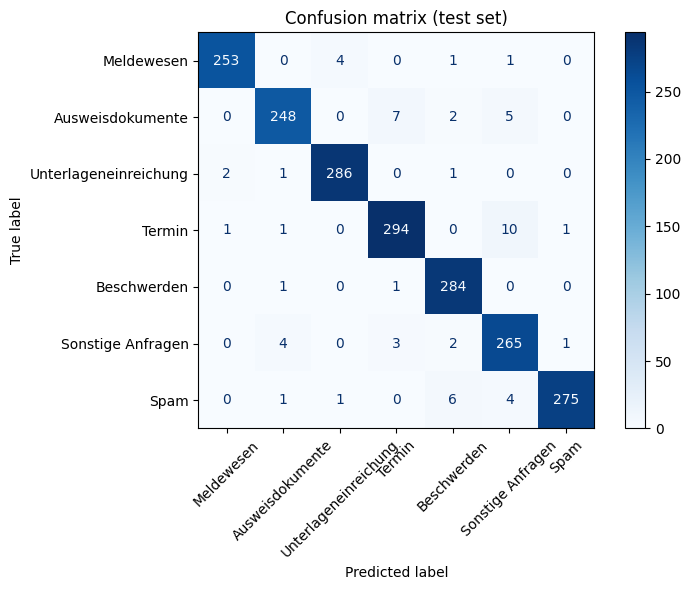

In [12]:
report_str = tools.evaluate_model(
    best_model,
    X_test,
    y_test,
    class_names,
    labels_for_cm=None,
    digits=4,
    show_cm=True,
    cm_figsize=(8,6),
    save_prefix="eval_"
)

Unser Modell hat mit einer Accuracy von knapp 97% insgesamt sehr gut abgeschnitten!

### **Eigene E-Mail eingeben und testen**

Testet nun selbst eine E-Mail an unserem Modell!

1. Tauscht den E-Mail-Text in rot aus und führt den Code aus, um die Vorhersage zu erhalten, welcher Klasse die E-Mail am ehesten zuzuordnen ist.
2. Entspricht das Predicted Label dem True Label?
3. Findet Ihr Fälle, in denen das Modell falsch kategorisiert?

In [13]:
tools.predict_own_email(df, model=best_model, class_names=class_names,
                        email_text="hallo, wirklich ärgerlich, wie lange das alles dauert! Mit freundlichen Grüßen")

📧 Email:

hallo, wirklich ärgerlich, wie lange das alles dauert! Mit freundlichen Grüßen

📊 Klassifizierungs-Wahrscheinlichkeiten:

Beschwerden: 0.419
Sonstige Anfragen: 0.356
Unterlageneinreichung: 0.085
Spam: 0.060
Meldewesen: 0.045
Ausweisdokumente: 0.028
Termin: 0.008

✅ Vorhergesagte Klasse: Beschwerden


'Beschwerden'

### **Wie gut ist der Klassifizierer wirklich?**

Eine Accuracy (d.h. richtige Kategorisierung) von 97% klingt nach einem sehr guten Klassifizierer und könnte viel Zeit einsparen...

Doch diese hohe Genauigkeit ist mit etwas Vorsicht zu interpretieren: Sie bezieht sich ausschließlich auf das Testset aus synthetisch generierten E-Mails und erlaubt keine direkte Aussage darüber, ob das Modell bei realen E-Mails eine vergleichbare Leistung erzielen würde.

In Fällen wie hier, wo sowohl Trainings- als auch Testdaten von einem LLM erzeugt wurden, kann eine sehr hohe Accuracy zudem irreführend sein, da das Modell primär die charakteristischen Sprachmuster und stilistischen Eigenheiten des verwendeten LLM lernt und nicht zwangsläufig auch die zugrunde liegende inhaltliche Aufgabe (wenngleich diese Aufgabe eher einfach und daher mit ein paar Keywords sehr zuverlässig zu lösen ist). Daher sollte, wenn das Modell tatsächlich eingesetzt werden soll, die Modellleistung immer mit realen, menschlich verfassten E-Mails überprüft werden!

### **Vergleich mit einem nichtlinearen Modell (XGBoost)**

Während die multinomiale logistische Regression eine leicht interpretierbare lineare Beziehung zwischen Merkmalen und Klassenwahrscheinlichkeiten herstellt, geht XGBoost einen Schritt weiter: Es kombiniert viele Entscheidungsbäume zu einem starken Ensemble und kann dadurch auch komplexe, nichtlineare Muster im Text besser erfassen. Allerdings steigert das die Genauigkeit nicht zwangsläufig, wie wir gleich sehen werden.

In [14]:
model, le, metrics = tools.xgboost_classifier(df, do_hyperparam_search=False)

Accuracy: 0.9458
Classification Report:
                       precision    recall  f1-score   support

     Ausweisdokumente       0.94      0.95      0.94       174
          Beschwerden       0.97      0.92      0.94       190
           Meldewesen       0.95      0.97      0.96       173
    Sonstige Anfragen       0.91      0.92      0.92       183
                 Spam       0.95      0.93      0.94       192
               Termin       0.93      0.96      0.94       205
Unterlageneinreichung       0.97      0.98      0.97       194

             accuracy                           0.95      1311
            macro avg       0.95      0.95      0.95      1311
         weighted avg       0.95      0.95      0.95      1311

Confusion Matrix:
[[165   1   1   1   1   3   2]
 [  1 174   3   2   7   1   2]
 [  1   0 167   2   0   3   0]
 [  5   1   2 169   2   4   0]
 [  0   2   1   6 178   4   1]
 [  1   1   1   4   0 197   1]
 [  3   0   0   1   0   0 190]]
['Spam', 'Spam']


In [15]:
# Testen wir die Vorhersage mit demselben Beispiel!
labels = tools.predict_texts(model, le, ["hallo, wirklich ärgerlich, wie lange das alles dauert! Mit freundlichen Grüßen"])
print(labels)

['Sonstige Anfragen']


XG-Boost hat also etwas schlechter abgeschnitten. Allerdings ist hier hinzuzufügen, dass wir die Hyperparameter nicht fine-getuned sind, was eine bessere Leistung verhindern könnte.

Letzte Frage an euch: Warum die E-Mails nicht einfach mit einem LLM klassifizieren? Im Gegensatz zu den beiden vorgestellten Modellen erfassen sie schließlich auch den Kontext der Emails!

# **Herzlichen Glückwunsch!**
### Ihr habt mit Eurem eigenen Machine Learning Model erfolgreich E-Mails kategorisiert.

Weitermachen? Probiert Euch gern an den [Machine Learning Tutorials von Andreas Müller und Sarah Guido](https://github.com/amueller/introduction_to_ml_with_python/tree/main) aus!
